<a href="https://colab.research.google.com/github/sb2539/AI-study/blob/master/mlpmixerosuleafgat(patches).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyts
!pip install einops
!pip install wandb

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
PATH = "/gdrive/MyDrive/model/"

Mounted at /gdrive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pylab as plt
import numpy as np
import pandas as pd
from pyts.image import RecurrencePlot, GramianAngularField, MarkovTransitionField
from pyts.datasets import fetch_ucr_dataset, ucr_dataset_list
from PIL import Image
from skimage.transform import resize
import os
from torch.utils.tensorboard import SummaryWriter
from einops.layers.torch import Rearrange, Reduce
import copy
import wandb

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.login()

wandb: Currently logged in as: sb2539. Use `wandb login --relogin` to force relogin


True

# syntcontrol


In [ ]:
wa = fetch_ucr_dataset('OSULeaf', use_cache=False, data_home = None, return_X_y=False)
wa_train = wa.data_train
wa_target_train = wa.target_train
wa_test = wa.data_test
wa_target_test = wa.target_test

In [ ]:
wa_test

In [ ]:
wa_target_val = wa_target_test[:100]
wa_val = wa_test[:100,:]

In [ ]:
wa_target_test

In [ ]:
rp = RecurrencePlot(dimension = 3,time_delay=4)
wa_train_rp = rp.transform(wa_train)
wa_test_rp = rp.transform(wa_test)

In [ ]:
gr_d = GramianAngularField(method='difference')
wa_train_gr_d = gr_d.transform(wa_train)
wa_test_gr_d = gr_d.transform(wa_test)
gr = GramianAngularField()
wa_train_gr = gr.transform(wa_train)
wa_test_gr = gr.transform(wa_test)

In [ ]:
mk = MarkovTransitionField()
wa_train_mk = mk.transform(wa_train)
wa_test_mk = mk.transform(wa_test)

In [ ]:
wa_train_rp = resize(wa_train_rp, ((200,64,64)))
wa_test_rp = resize(wa_test_rp, ((242,64,64)))
wa_train_gr = resize(wa_train_gr, ((200,64,64)))
wa_test_gr = resize(wa_test_gr, ((242,64,64)))
wa_train_gr_d = resize(wa_train_gr_d, ((200,64,64)))
wa_test_gr_d = resize(wa_test_gr_d, ((242,64,64)))
wa_train_mk = resize(wa_train_mk, ((200,64,64)))
wa_test_mk = resize(wa_test_mk, ((242,64,64)))

In [ ]:
wa_train_all = np.stack([wa_train_rp, wa_train_gr, wa_train_gr_d], 1)
wa_test_all = np.stack([wa_test_rp, wa_test_gr, wa_test_gr_d], 1)

In [ ]:
wa_train_all = np.stack([wa_train_rp, wa_train_gr,wa_train_gr_d], 1)
wa_test_all = np.stack([wa_test_rp, wa_test_gr, wa_test_gr_d], 1)

In [ ]:
train_data = CustomDataset(wa_train_all, wa_target_train)
trainloader = DataLoader(train_data, batch_size = 5, shuffle = True)
test_data = CustomDataset(wa_test_all, wa_target_test)
testloader = DataLoader(test_data, batch_size = 5, shuffle = False )

In [ ]:
val_data = CustomDataset(val_all,wa_target_val)
valloader = DataLoader(val_data, batch_size = 5, shuffle = False)

In [ ]:
wa_train_rp = resize(wa_train_rp, ((300,56,56)))
wa_test_rp = resize(wa_test_rp, ((300,56,56)))
wa_train_rp = wa_train_rp.reshape(300, 1, 56, 56)
wa_test_rp = wa_test_rp.reshape(300, 1, 56, 56)
train_data = CustomDataset(wa_train_rp, wa_target_train)
trainloader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_data = CustomDataset(wa_test_rp, wa_target_test)
testloader = DataLoader(test_data, batch_size = 10, shuffle = False )

# customdata

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, rpimage, target_image):
        self.x_data = torch.FloatTensor(rpimage)
        self.y_data = torch.LongTensor(target_image)
        self.y_data = self.y_data-1
    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# mlp

In [ ]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
class MixerBlock(nn.Module):
    def __init__(self, dim, num_patch, token_dim, channel_dim, dropout = 0.):
        super(MixerBlock, self).__init__()

        self.token_mix = nn.Sequential(
            nn.LayerNorm(dim),
            Rearrange('b n d -> b d n'), #(n_samples, n_patches, dim) -> (n_samples, dim, n_patches)
            MLP(num_patch, token_dim, dropout),
            Rearrange('b d n -> b n d')  # 원상복구
        )

        self.channel_mix = nn.Sequential(
            nn.LayerNorm(dim),
            MLP(dim, channel_dim, dropout),
        )

    def forward(self, x):
        x = x + self.token_mix(x)  # skip connection 부분
        x = x + self.channel_mix(x) # skip connection 부분
        return x

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, num_patch, dim, dropout, alpha, use_bias = False):
        super(AttentionLayer, self). __init__()
        self.n_features = num_patch
        self.num_nodes = num_patch
        self.dim = dim
        self.dropout = dropout
        self.use_bias = use_bias

        lin_input_dim = dim
        a_input_dim = 2 * self.dim   # 64

        self.lin = nn.Linear(lin_input_dim, self.dim) # (64,32)
        self.a = nn.Parameter(torch.empty((a_input_dim, 1))) #(64)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        if self.use_bias:
            self.bias = nn.Parameter(torch.empty(num_patch, num_patch))

        self.leakyrelu = nn.LeakyReLU(alpha)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #x = x.permute(0, 2, 1)
        Wx = self.lin(x)  # (64, 32)
        a_input = self._make_attention_input(Wx) #(5, 64, 64, 64)
        e = self.leakyrelu(torch.matmul(a_input, self.a)).squeeze(3) #(5, 64,64,1)

        if self.use_bias:
            e+=self.bias

        attention = torch.softmax(e, dim = 2)
        h = self.sigmoid(torch.matmul(attention, x)) # (5, 64, 64) * (64, 128)
        return h #h.permute(0,2,1)
        
    def _make_attention_input(self, v):
        K = self.num_nodes
        blocks_repeating = v.repeat_interleave(K, dim = 1)
        blocks_alternating = v.repeat(1, K, 1)
        combined = torch.cat((blocks_repeating, blocks_alternating), dim = 2)

        return combined.view(v.size(0), K, K, 2 * self.dim)

In [ ]:
class MLPMixer(nn.Module):
    def __init__(self, in_channels, dim, num_classes, patch_size, image_size, depth, token_dim, channel_dim, dropout = 0., alpha = 0.2):
        super(MLPMixer, self).__init__()
        self.dropout = dropout
        assert image_size % patch_size == 0 # 이미지 사이즈가 패치 사이즈로 나누어져야 함
        self.num_patch = (image_size // patch_size) **2 # num_patch = 64 , img_size = 64, patch_size = 8
        self.patch_embedding = nn.Sequential(
            nn.Conv2d(in_channels, dim, patch_size, patch_size), # (in_channel = 3, out_channel=32, kernel = 8,stride =  8)
            Rearrange('b c h w -> b (h w) c') #(5, 32, 8, 8) -> (5, 64, 32)
        )                                     # 64 * 512 matrix 만들어짐
        self.patch_gat = AttentionLayer(self.num_patch, dim, dropout, alpha)
        self.mixer_blocks = nn.ModuleList([])
        for _ in range(depth):     # depth = 8 만큼 
            self.mixer_blocks.append(
                MixerBlock(dim, self.num_patch, token_dim, channel_dim, dropout) #(512, 64, 256, 2048 )
            )

        self.layer_norm = nn.LayerNorm(dim)
        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, x): # 입력 (5, 3, 64, 64)
        x = self.patch_embedding(x)  # (5, 64, 32)
        x = self.patch_gat(x) #(5, 64, 32)
        for mixer_block in self.mixer_blocks:
            x = mixer_block(x) # (1, 64, 512)
        x = self.layer_norm(x)
        x = x.mean(dim = 1) # global average pooling (1, 512)
        x = self.mlp_head(x) # (1, 5)
        return x

# weight & bias

In [ ]:
PATH = "/gdrive/MyDrive/model/"
global best_acc 
best_acc = 0

In [ ]:
def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer

In [ ]:
def train(model, trainloader, testloader, criterion, optimizer, config, wandb):
    global best_acc
    model.train()
    wandb.watch(model, criterion, log="all", log_freq=10)
    for epoch in range(config.epochs):
        cumu_loss = 0
        correct = 0
        val_correct = 0
        target_loss = 0
        for data in trainloader:
            input, target  = data

            output = model(input)
            loss = criterion(output, target)
            cumu_loss += loss.item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else :
            with torch.no_grad():
                for data in testloader:
                    input, target = data
                    output = model(input)
                    target_loss += criterion(output, target).item()
                    pred = output.max(1, keepdim=True)[1]
                    val_correct += pred.eq(target.view_as(pred)).sum().item()

        val_loss = target_loss / len(testloader)
        avg_loss = cumu_loss / len(trainloader)
        train_acc = 100. * correct / len(trainloader.dataset)
        val_acc = 100. * val_correct / len(testloader.dataset)
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), PATH + 'osuleafgat_mlp_state_dictonly_rp_gr_grd.pt')
            print("saved")
        wandb.log({"train_loss": avg_loss, "train_acc":train_acc}, step=epoch)  
        print(f"TRAIN: EPOCH {epoch + 1:04d} / {config.epochs:04d} | Epoch LOSS {avg_loss:.4f} | Epoch ACC {train_acc:.4f} | Val Loss {val_loss:.4f} | Val_acc {val_acc:.4f}")

In [ ]:
def test(model, loader, criterion, wandb):
    model.eval()

    with torch.no_grad():
        correct, target_loss = 0, 0
        for data in loader:
            input, target = data
            output = model(input)
            
            target_loss += criterion(output, target).item()
            
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    
    test_loss = target_loss / len(loader)
    test_acc = 100. * correct / len(loader.dataset)
    print(f"test: LOSS {test_loss:.4f} | Accuracy {test_acc:.4f} ")
    wandb.log({
        "test_acc": test_acc,
        "test_loss": test_loss})

In [ ]:
sweep_config = {
    'name' : 'osu_rp_gr_grd-gat-sweep',
    'method' : 'random',
    'metric' : {
        'name': 'test_acc',
        'goal': 'maximize'
    },
    'parameters':{
        'optimizer':{
            'values':['adam']
        },
        'dropout':{
            'values':[0.,0.3,0.5]
        },
        'learning_rate':{
            'distribution':'uniform',
            'min':0.0001,
            'max':0.001
        },
        'epochs':{
            'values': [60]
        },
        'hidden_size':{
            'values': [32, 64, 128, 256]
        },
        'patch_size':{
            'values': [4,8,16]
        },
        'number_of_layers':{
            'values':[4,8, 16]
        },
        'token_dim':{
            'values':[32, 64, 128, 256]
        },
        'channel_dim':{
            'values':[32, 64, 128,256]
        },
        'alpha':{
            'values':[0.2]
        }
    }
}

In [ ]:
def run_sweeep(config=None):
    wandb.init(config=config, entity='sb2539')
    w_config = wandb.config
    criterion = nn.CrossEntropyLoss()
    in_channels = 3
    num_classes = 6
    resolution = 64
    model = MLPMixer(
        in_channels = in_channels,
        dim = w_config.hidden_size,
        num_classes = num_classes,
        patch_size = w_config.patch_size,
        image_size = resolution,
        depth = w_config.number_of_layers,
        token_dim = w_config.token_dim,
        channel_dim = w_config.channel_dim,
        dropout = w_config.dropout,
        alpha = w_config.alpha
    )
    optimizer = build_optimizer(model, w_config.optimizer, w_config.learning_rate)

    train(model, trainloader, testloader, criterion, optimizer,  w_config, wandb)
    test(model, testloader, criterion, wandb)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="osuleaf_mlp_only_rp_gr_grd-gat2", entity='sb2539')
wandb.agent(sweep_id, run_sweeep, count=100)

Create sweep with ID: 3idk05q8
Sweep URL: https://wandb.ai/sb2539/osuleaf_mlp_only_rp_gr_grd-gat2/sweeps/3idk05q8


wandb: Agent Starting Run: xsya1gjc with config:
wandb: 	alpha: 0.2
wandb: 	channel_dim: 128
wandb: 	dropout: 0
wandb: 	epochs: 60
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0005494287581245586
wandb: 	number_of_layers: 8
wandb: 	optimizer: adam
wandb: 	patch_size: 8
wandb: 	token_dim: 256
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


TRAIN: EPOCH 0001 / 0060 | Epoch LOSS 1.7882 | Epoch ACC 19.0000 | Val Loss 1.7431 | Val_acc 22.3140
TRAIN: EPOCH 0002 / 0060 | Epoch LOSS 1.6613 | Epoch ACC 33.0000 | Val Loss 1.6071 | Val_acc 32.2314
TRAIN: EPOCH 0003 / 0060 | Epoch LOSS 1.4764 | Epoch ACC 42.5000 | Val Loss 1.6010 | Val_acc 30.5785
TRAIN: EPOCH 0004 / 0060 | Epoch LOSS 1.4722 | Epoch ACC 39.5000 | Val Loss 1.5815 | Val_acc 30.9917
TRAIN: EPOCH 0005 / 0060 | Epoch LOSS 1.4999 | Epoch ACC 40.5000 | Val Loss 1.6520 | Val_acc 31.8182
TRAIN: EPOCH 0006 / 0060 | Epoch LOSS 1.4254 | Epoch ACC 43.5000 | Val Loss 1.4842 | Val_acc 32.6446
TRAIN: EPOCH 0007 / 0060 | Epoch LOSS 1.3238 | Epoch ACC 45.5000 | Val Loss 1.3926 | Val_acc 44.2149
TRAIN: EPOCH 0008 / 0060 | Epoch LOSS 1.3318 | Epoch ACC 47.0000 | Val Loss 1.4171 | Val_acc 38.0165
TRAIN: EPOCH 0009 / 0060 | Epoch LOSS 1.2534 | Epoch ACC 49.0000 | Val Loss 1.4911 | Val_acc 36.7769
TRAIN: EPOCH 0010 / 0060 | Epoch LOSS 1.2033 | Epoch ACC 50.5000 | Val Loss 1.3754 | Val_ac

test_acc,▁
test_loss,▁
train_acc,▁▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▅▆▇▆▆▆▇▆▆▆▇▇▇▇▆▇▇▇▇███▇█
train_loss,█▇▆▇▆▆▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁
test_acc,46.69421
test_loss,1.63665
train_acc,85.5
train_loss,0.40869


wandb: Agent Starting Run: pi9rtukg with config:
wandb: 	alpha: 0.2
wandb: 	channel_dim: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 60
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0007502484495053897
wandb: 	number_of_layers: 8
wandb: 	optimizer: adam
wandb: 	patch_size: 16
wandb: 	token_dim: 128
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


TRAIN: EPOCH 0001 / 0060 | Epoch LOSS 1.8197 | Epoch ACC 22.0000 | Val Loss 1.7788 | Val_acc 16.1157
TRAIN: EPOCH 0002 / 0060 | Epoch LOSS 1.7688 | Epoch ACC 16.0000 | Val Loss 1.8170 | Val_acc 18.1818
TRAIN: EPOCH 0003 / 0060 | Epoch LOSS 1.7572 | Epoch ACC 26.5000 | Val Loss 1.7791 | Val_acc 18.1818
TRAIN: EPOCH 0004 / 0060 | Epoch LOSS 1.7582 | Epoch ACC 24.0000 | Val Loss 1.8062 | Val_acc 18.1818
TRAIN: EPOCH 0005 / 0060 | Epoch LOSS 1.7401 | Epoch ACC 25.5000 | Val Loss 1.7692 | Val_acc 22.7273
TRAIN: EPOCH 0006 / 0060 | Epoch LOSS 1.7028 | Epoch ACC 29.5000 | Val Loss 1.8054 | Val_acc 18.5950
TRAIN: EPOCH 0007 / 0060 | Epoch LOSS 1.6736 | Epoch ACC 29.5000 | Val Loss 1.7090 | Val_acc 29.7521
TRAIN: EPOCH 0008 / 0060 | Epoch LOSS 1.5842 | Epoch ACC 35.5000 | Val Loss 1.7086 | Val_acc 30.5785
TRAIN: EPOCH 0009 / 0060 | Epoch LOSS 1.4875 | Epoch ACC 37.5000 | Val Loss 1.6557 | Val_acc 31.4050
TRAIN: EPOCH 0010 / 0060 | Epoch LOSS 1.4822 | Epoch ACC 40.5000 | Val Loss 1.5414 | Val_ac

test_acc,▁
test_loss,▁
train_acc,▂▁▂▂▃▄▄▄▅▅▅▅▅▅▅▆▆▅▇▆▆▆▆▇▆▆▆▇▆▇▇▇▆▆▇▇▇▆▇█
train_loss,███▇▇▆▆▆▅▅▅▅▅▅▄▄▄▅▃▄▃▄▃▂▃▃▄▂▃▂▂▂▃▃▂▂▃▄▂▁
test_acc,37.60331
test_loss,1.92351
train_acc,70.0
train_loss,0.79263


wandb: Agent Starting Run: dxgevfer with config:
wandb: 	alpha: 0.2
wandb: 	channel_dim: 64
wandb: 	dropout: 0.5
wandb: 	epochs: 60
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0007124166351016572
wandb: 	number_of_layers: 16
wandb: 	optimizer: adam
wandb: 	patch_size: 8
wandb: 	token_dim: 256
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


TRAIN: EPOCH 0001 / 0060 | Epoch LOSS 1.7700 | Epoch ACC 26.5000 | Val Loss 1.7955 | Val_acc 18.1818
TRAIN: EPOCH 0002 / 0060 | Epoch LOSS 1.7458 | Epoch ACC 25.5000 | Val Loss 1.7806 | Val_acc 18.1818
TRAIN: EPOCH 0003 / 0060 | Epoch LOSS 1.6412 | Epoch ACC 36.5000 | Val Loss 1.6504 | Val_acc 28.5124
TRAIN: EPOCH 0004 / 0060 | Epoch LOSS 1.6023 | Epoch ACC 33.0000 | Val Loss 2.0700 | Val_acc 24.7934
TRAIN: EPOCH 0005 / 0060 | Epoch LOSS 1.7424 | Epoch ACC 24.0000 | Val Loss 1.7424 | Val_acc 19.0083
TRAIN: EPOCH 0006 / 0060 | Epoch LOSS 1.5856 | Epoch ACC 38.0000 | Val Loss 1.5578 | Val_acc 35.9504
TRAIN: EPOCH 0007 / 0060 | Epoch LOSS 1.4334 | Epoch ACC 46.0000 | Val Loss 1.5116 | Val_acc 33.4711
TRAIN: EPOCH 0008 / 0060 | Epoch LOSS 1.3758 | Epoch ACC 45.5000 | Val Loss 1.5165 | Val_acc 35.9504
TRAIN: EPOCH 0009 / 0060 | Epoch LOSS 1.4021 | Epoch ACC 44.5000 | Val Loss 1.4587 | Val_acc 38.0165
TRAIN: EPOCH 0010 / 0060 | Epoch LOSS 1.3524 | Epoch ACC 43.5000 | Val Loss 1.4338 | Val_ac

test_acc,▁
test_loss,▁
train_acc,▁▁▂▁▄▄▄▄▅▄▅▅▄▅▅▅▆▆▆▆▆▆▆▆▆▆▇▆▆▆▆▇▇▇██▇▇▇█
train_loss,██▇█▆▆▆▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▃▃▂▃▃▃▃▃▃▃▂▂▁▂▂▂▁▁
test_acc,46.69421
test_loss,1.91053
train_acc,76.0
train_loss,0.60955


wandb: Agent Starting Run: y71qion6 with config:
wandb: 	alpha: 0.2
wandb: 	channel_dim: 64
wandb: 	dropout: 0
wandb: 	epochs: 60
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0008043326793268523
wandb: 	number_of_layers: 16
wandb: 	optimizer: adam
wandb: 	patch_size: 4
wandb: 	token_dim: 32
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


TRAIN: EPOCH 0001 / 0060 | Epoch LOSS 1.8099 | Epoch ACC 23.5000 | Val Loss 1.7815 | Val_acc 18.1818
TRAIN: EPOCH 0002 / 0060 | Epoch LOSS 1.7514 | Epoch ACC 26.5000 | Val Loss 1.7830 | Val_acc 18.1818
TRAIN: EPOCH 0003 / 0060 | Epoch LOSS 1.7451 | Epoch ACC 26.5000 | Val Loss 1.7715 | Val_acc 18.1818
TRAIN: EPOCH 0004 / 0060 | Epoch LOSS 1.7119 | Epoch ACC 28.0000 | Val Loss 1.7103 | Val_acc 28.9256
TRAIN: EPOCH 0005 / 0060 | Epoch LOSS 1.6073 | Epoch ACC 38.0000 | Val Loss 1.6488 | Val_acc 29.3388
TRAIN: EPOCH 0006 / 0060 | Epoch LOSS 1.5230 | Epoch ACC 41.5000 | Val Loss 1.5526 | Val_acc 31.8182
TRAIN: EPOCH 0007 / 0060 | Epoch LOSS 1.4360 | Epoch ACC 38.5000 | Val Loss 1.5378 | Val_acc 36.3636
TRAIN: EPOCH 0008 / 0060 | Epoch LOSS 1.4228 | Epoch ACC 42.5000 | Val Loss 1.5317 | Val_acc 36.3636
TRAIN: EPOCH 0009 / 0060 | Epoch LOSS 1.3842 | Epoch ACC 47.0000 | Val Loss 1.5133 | Val_acc 34.7107
TRAIN: EPOCH 0010 / 0060 | Epoch LOSS 1.3914 | Epoch ACC 46.0000 | Val Loss 1.4947 | Val_ac

In [ ]:
channel_dim: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001603898674692116
wandb: 	number_of_layers: 4
wandb: 	optimizer: adam
wandb: 	patch_size: 8
wandb: 	token_dim: 64

In [ ]:
if __name__ == "__main__":
    from torchsummary import summary
    import pdb
 
    # base_model_param0.0009                        
    in_channels = 3                        
    hidden_size = 64                    
    num_classes = 6                        
    patch_size = 4                         
    resolution = 64                            
    number_of_layers = 4                    
    token_dim = 16                         
    channel_dim = 256                  
    dropout = 0.3
    alpha = 0.2                                         

    model = MLPMixer(
        in_channels = in_channels,
        dim = hidden_size,
        num_classes = num_classes,
        patch_size = patch_size,
        image_size = resolution,
        depth = number_of_layers,
        token_dim = token_dim,
        channel_dim = channel_dim,
        dropout = dropout,
        alpha = alpha
    )
    
    summary(model, (3,64,64), device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,136
         Rearrange-2              [-1, 256, 64]               0
            Linear-3              [-1, 256, 64]           4,160
         LeakyReLU-4          [-1, 256, 256, 1]               0
           Sigmoid-5              [-1, 256, 64]               0
    AttentionLayer-6              [-1, 256, 64]               0
         LayerNorm-7              [-1, 256, 64]             128
         Rearrange-8              [-1, 64, 256]               0
            Linear-9               [-1, 64, 16]           4,112
             GELU-10               [-1, 64, 16]               0
          Dropout-11               [-1, 64, 16]               0
           Linear-12              [-1, 64, 256]           4,352
          Dropout-13              [-1, 64, 256]               0
              MLP-14              [-1, 

In [ ]:
if __name__ == "__main__":
    from torchsummary import summary
    import pdb
        
    # base_model_param0.0009                        
    in_channels = 3                        
    hidden_size = 64                    
    num_classes = 6                        
    patch_size = 4                         
    resolution = 64                            
    number_of_layers = 4                    
    token_dim = 16                         
    channel_dim = 256                  
    dropout = 0.3
    alpha = 0.2                                                #0          0.1

    model = MLPMixer(
        in_channels = in_channels,
        dim = hidden_size,
        num_classes = num_classes,
        patch_size = patch_size,
        image_size = resolution,
        depth = number_of_layers,
        token_dim = token_dim,
        channel_dim = channel_dim,
        dropout = dropout
    )

PATH = "/gdrive/MyDrive/model/"
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(cnn.parameters(), lr = 0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr = 0.0009)
#scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch:0.95**epoch,last_epoch = -1, verbose = False)
loss_list = []
iter = []
train_accuracy = []
validation_loss = []
validation_acc = []    

model.train()
epochs = 30
for epoch in range(epochs):
    running_loss = 0.0
    val_running_loss = 0.0
    correct = 0.0
    val_correct = 0.0
    total = 0.0
    val_total = 0
    for data in trainloader:
        input,target = data
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(output.data, 1)
        correct += preds.eq(target).sum().item()
        running_loss += loss.item()
    
        
    else:
        with torch.no_grad():
            for data in testloader:
                val_input, val_target = data
                val_outputs = model(val_input)
                val_loss = criterion(val_outputs, val_target)
                
                _, val_pred = torch.max(val_outputs, 1)
                val_running_loss  += val_loss.item()
                val_correct += val_pred.eq(val_target).sum().item()
        

    training_loss = running_loss/len(trainloader)
    val_loss = val_running_loss/len(testloader)
    train_acc = 100*correct/len(trainloader.dataset)
    val_acc = 100*val_correct/len(testloader.dataset)
    if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), PATH + 'osuleaf_mlp_state_dictonly_rp_gr_gr_d.pt')
            print("saved")
    print("=============================================================================================================================================================")
    print(f"TRAIN: EPOCH {epoch + 1:04d} / {epochs:04d} | Epoch LOSS {training_loss:.4f} | Epoch ACC {train_acc:.4f} | Val Loss {val_loss:.4f} | Val_acc {val_acc:.4f}")
    cost = running_loss/6
    loss_list.append(training_loss)
    train_accuracy.append(train_acc)
    validation_loss.append(val_loss)
    validation_acc.append(val_acc)
    running_loss = 0.0
print('finish')

KeyboardInterrupt: ignored

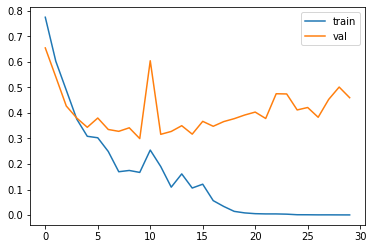

In [ ]:
plt.plot(loss_list, label='trainloss')
plt.plot(validation_loss, label='val_loss')
plt.legend(['train', 'val'])
plt.show()

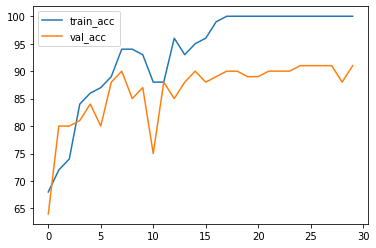

In [ ]:
plt.plot(train_accuracy, label='trainaccuracy')
plt.plot(validation_acc, label='val_acc')
plt.legend(['train_acc', 'val_acc'])
plt.show()

In [ ]:
#model = torch.load(PATH + 'mlp.pt')
model.load_state_dict(copy.deepcopy(torch.load(PATH + 'fish_mlp_state_dict2.pt')))


<All keys matched successfully>

In [ ]:
model.load_state_dict(copy.deepcopy(torch.load(PATH + 'osuleafgat_mlp_state_dictonly_rp_gr_grd.pt')))

<All keys matched successfully>

In [ ]:
correct = 0
total = 0
accuracy = []
iter_acc = []
test_loss = []
b=0
model.eval()
with torch.no_grad():
    for data in testloader :
        b+=1
        images, labels = data
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        iter_acc.append(b)
        cost = 100*correct/total
        accuracy.append(cost)
        
    test_loss.append(loss)
    error_rate = 1-(correct/total)
    test_acc = 100. * correct / len(testloader.dataset)
print('accuracy of testimages: %d %%' %(100*correct/total))
print('error rate : ', format(error_rate, ".3f"))
print(f"Val_acc {test_acc:.4f}")



accuracy of testimages: 63 %
error rate :  0.368
Val_acc 63.2231


In [ ]:
val_correct = 0
model.eval()
with torch.no_grad():
    for data in testloader:
        val_input, val_target = data
        val_outputs = model(val_input)
        val_loss = criterion(val_outputs, val_target)
        _, val_pred = torch.max(val_outputs, 1)
        val_correct += val_pred.eq(val_target).sum().item()

    val_acc = 100. * val_correct/len(testloader.dataset)
    error_rate = 1-(val_correct/len(testloader.dataset))
print("=============================================================")
print(f"test acc {val_acc:.4f} | error rate {error_rate:.4f}")

test acc 59.3333 | error rate 0.4067


In [ ]:
torch.save(model.state_dict(), PATH + 'olive86_mlp_state_dict.pt')